In [14]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from nistats.second_level_model import SecondLevelModel
from nistats.design_matrix import make_second_level_design_matrix
from nistats.reporting import plot_design_matrix, get_clusters_table
from nistats.thresholding import map_threshold
from nilearn import plotting

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Statistical comparisons of R2 maps =========================================================

In [2]:
#Load the R2 maps generated from the previously run dypac embeddings model.
path_base = '/home/lussier/Projects/'
r2_path = 'data/abide/r2maps/'
r2maps = glob(os.path.join(path_base,r2_path, '*.nii.gz'))
print(r2maps)

['/home/lussier/Projects/data/abide/r2maps/sub_191.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_14.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_85.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_316.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_387.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_1.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_251.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_582.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_485.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_300.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_117.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_53.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_514.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_583.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_713.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_206.nii.gz', '/home/lussier/Projects/data/abide/r2maps/sub_252.nii.gz', '

In [3]:
# Load the .csv with the phenotypic data 
behavioral = pd.read_csv('/home/lussier/Projects/embeddings/pheno_test.csv', header = 0, sep=',')
for row in behavioral:
    print(row)

SITE_ID
FILEID
SUB_ID
site_name
SITE_RECODE
DX_GROUP
DX_GROUP_RECODE
DSM_IV_TR
AGE_AT_SCAN
SEX
SEX_RECODE
HANDEDNESS_CATEGORY
HANDEDNESS_SCORES
FIQ
VIQ
PIQ
FIQ_TEST_TYPE
VIQ_TEST_TYPE
PIQ_TEST_TYPE
ADI_R_SOCIAL_TOTAL_A
ADI_R_VERBAL_TOTAL_BV
ADI_RRB_TOTAL_C
ADI_R_ONSET_TOTAL_D
ADI_R_RSRCH_RELIABLE
ADOS_MODULE
ADOS_TOTAL
ADOS_COMM
ADOS_SOCIAL
ADOS_STEREO_BEHAV
ADOS_RSRCH_RELIABLE
ADOS_GOTHAM_SOCAFFECT
ADOS_GOTHAM_RRB
ADOS_GOTHAM_TOTAL
ADOS_GOTHAM_SEVERITY
SRS_VERSION
SRS_RAW_TOTAL
SRS_AWARENESS
SRS_COGNITION
SRS_COMMUNICATION
SRS_MOTIVATION
SRS_MANNERISMS
SCQ_TOTAL
AQ_TOTAL
COMORBIDITY
CURRENT_MED_STATUS
MEDICATION_NAME
OFF_STIMULANTS_AT_SCAN
VINELAND_RECEPTIVE_V_SCALED
VINELAND_EXPRESSIVE_V_SCALED
VINELAND_WRITTEN_V_SCALED
VINELAND_COMMUNICATION_STANDARD
VINELAND_PERSONAL_V_SCALED
VINELAND_DOMESTIC_V_SCALED
VINELAND_COMMUNITY_V_SCALED
VINELAND_DAILYLVNG_STANDARD
VINELAND_INTERPERSONAL_V_SCALED
VINELAND_PLAY_V_SCALED
VINELAND_COPING_V_SCALED
VINELAND_SOCIAL_STANDARD
VINELAND_SUM_SCORES
V

In [4]:
#Load the file id from the csv
file_id = behavioral['FILEID'].values
print(file_id)

['sub_0.nii.gz' 'sub_1.nii.gz' 'sub_2.nii.gz' 'sub_3.nii.gz'
 'sub_4.nii.gz' 'sub_5.nii.gz' 'sub_6.nii.gz' 'sub_7.nii.gz'
 'sub_8.nii.gz' 'sub_9.nii.gz' 'sub_10.nii.gz' 'sub_11.nii.gz'
 'sub_12.nii.gz' 'sub_13.nii.gz' 'sub_14.nii.gz' 'sub_15.nii.gz'
 'sub_16.nii.gz' 'sub_17.nii.gz' 'sub_18.nii.gz' 'sub_19.nii.gz'
 'sub_20.nii.gz' 'sub_21.nii.gz' 'sub_22.nii.gz' 'sub_23.nii.gz'
 'sub_24.nii.gz' 'sub_25.nii.gz' 'sub_26.nii.gz' 'sub_27.nii.gz'
 'sub_28.nii.gz' 'sub_29.nii.gz' 'sub_30.nii.gz' 'sub_31.nii.gz'
 'sub_32.nii.gz' 'sub_33.nii.gz' 'sub_34.nii.gz' 'sub_35.nii.gz'
 'sub_36.nii.gz' 'sub_37.nii.gz' 'sub_38.nii.gz' 'sub_39.nii.gz'
 'sub_40.nii.gz' 'sub_41.nii.gz' 'sub_42.nii.gz' 'sub_43.nii.gz'
 'sub_44.nii.gz' 'sub_45.nii.gz' 'sub_46.nii.gz' 'sub_47.nii.gz'
 'sub_48.nii.gz' 'sub_49.nii.gz' 'sub_50.nii.gz' 'sub_51.nii.gz'
 'sub_52.nii.gz' 'sub_53.nii.gz' 'sub_54.nii.gz' 'sub_55.nii.gz'
 'sub_56.nii.gz' 'sub_57.nii.gz' 'sub_58.nii.gz' 'sub_59.nii.gz'
 'sub_60.nii.gz' 'sub_61.nii.gz' 's

In [5]:
#Load the condition of interest by header name
#The conditions must be recoded numeric values and not strings
conditions = behavioral['DX_GROUP_RECODE'].values
print(conditions)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 

Build a design matrix
==================

In [6]:
confounds = pd.DataFrame({'subject_label': file_id,
                          'conditions': conditions,
                          'sex': behavioral['SEX_RECODE'],
                          'age': behavioral['AGE_AT_SCAN'],
                          'site': behavioral['SITE_RECODE']
                         })
print(confounds)

      subject_label  conditions  sex    age  site
0      sub_0.nii.gz           1    0  19.09     0
1      sub_1.nii.gz           1    0  13.37     0
2      sub_2.nii.gz           1    0  17.78     0
3      sub_3.nii.gz           1    0  32.45     0
4      sub_4.nii.gz           1    0  33.86     0
..              ...         ...  ...    ...   ...
755  sub_755.nii.gz           1    0  31.00    18
756  sub_756.nii.gz           1    0  35.00    18
757  sub_757.nii.gz           1    0  27.00    18
758  sub_758.nii.gz           1    1  29.00    13
759  sub_759.nii.gz           1    0  26.00    13

[760 rows x 5 columns]


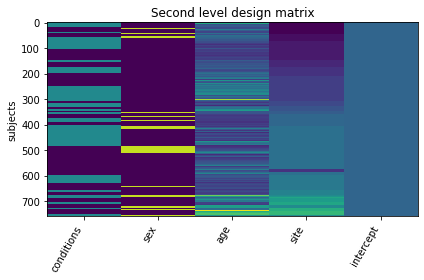

In [7]:
design_matrix = make_second_level_design_matrix(file_id, confounds)

ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('subjects')
plt.tight_layout()
plt.show()

Second level model estimation
===========================================

In [9]:
second_level_input = r2maps
second_level_model = SecondLevelModel().fit(
        second_level_input, design_matrix=design_matrix)

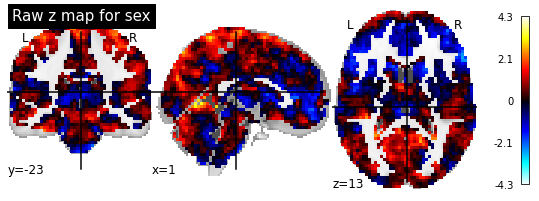

In [10]:
zmap_sex = second_level_model.compute_contrast(
    'sex', output_type='z_score')
plotting.plot_stat_map(zmap_sex, title='Raw z map for sex')
plotting.show()

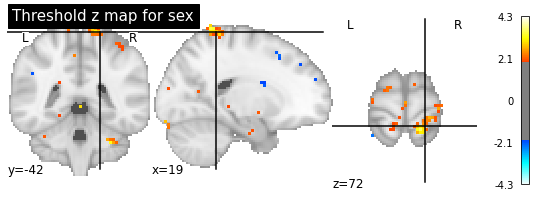

In [11]:
plotting.plot_stat_map(zmap_sex, threshold=2, title='Threshold z map for sex')
plotting.show()

Bonferroni-corrected, p<0.05 threshold: 4.900


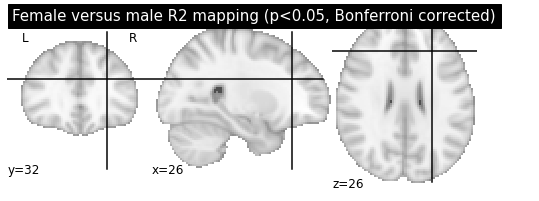

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [23]:
_, threshold = map_threshold(zmap_sex, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_sex, threshold=threshold, 
              title='Female versus male R2 mapping (p<0.05, Bonferroni corrected)')
plt.show()

get_clusters_table(zmap_sex, stat_threshold=threshold, cluster_threshold=None)

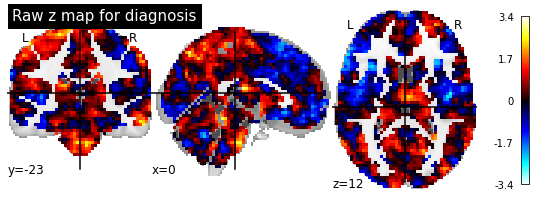

In [25]:
zmap_conditions = second_level_model.compute_contrast(
    'conditions', output_type='z_score')
plotting.plot_stat_map(zmap_conditions, title='Raw z map for diagnosis')
plotting.show()

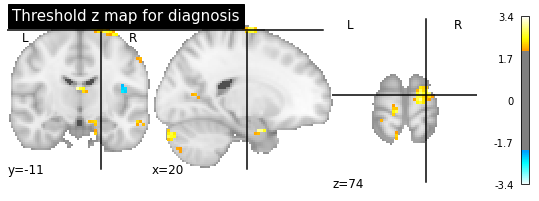

In [26]:
plotting.plot_stat_map(zmap_conditions, threshold=2, title='Threshold z map for diagnosis')
plotting.show()

Bonferroni-corrected, p<0.05 threshold: 4.900


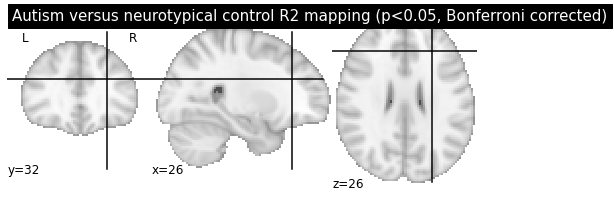

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [27]:
_, threshold = map_threshold(zmap_conditions, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_conditions, threshold=threshold, 
              title='Autism versus neurotypical control R2 mapping (p<0.05, Bonferroni corrected)')
plt.show()

get_clusters_table(zmap_conditions, stat_threshold=threshold, cluster_threshold=None)

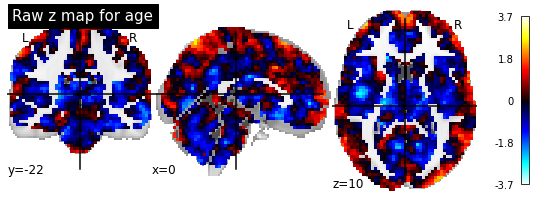

In [28]:
zmap_age = second_level_model.compute_contrast(
    'age', output_type='z_score')
plotting.plot_stat_map(zmap_age, title='Raw z map for age')
plotting.show()

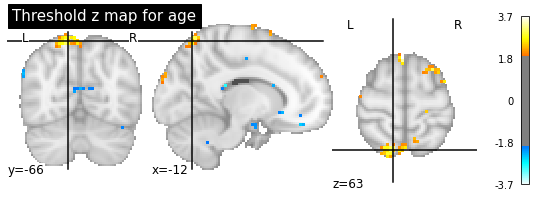

In [29]:
plotting.plot_stat_map(zmap_age, threshold=2, title='Threshold z map for age')
plotting.show()

Bonferroni-corrected, p<0.05 threshold: 4.900


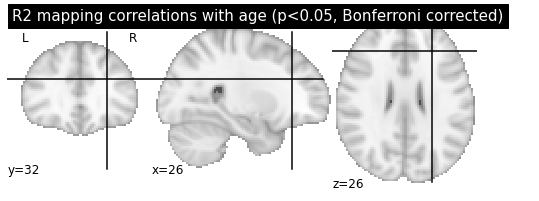

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [30]:
_, threshold = map_threshold(zmap_age, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_age, threshold=threshold, 
              title='R2 mapping correlations with age (p<0.05, Bonferroni corrected)')
plt.show()

get_clusters_table(zmap_age, stat_threshold=threshold, cluster_threshold=None)

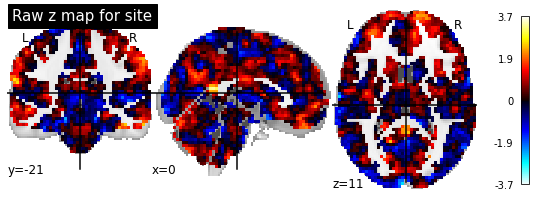

In [31]:
zmap_site = second_level_model.compute_contrast(
    'site', output_type='z_score')
plotting.plot_stat_map(zmap_site, title='Raw z map for site')
plotting.show()

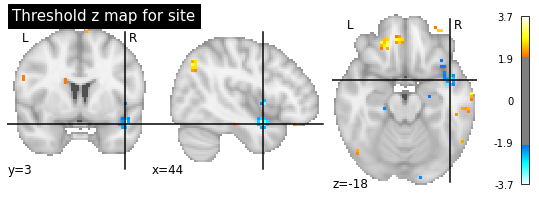

In [32]:
plotting.plot_stat_map(zmap_site, threshold=2, title='Threshold z map for site')
plotting.show()

Bonferroni-corrected, p<0.05 threshold: 4.900


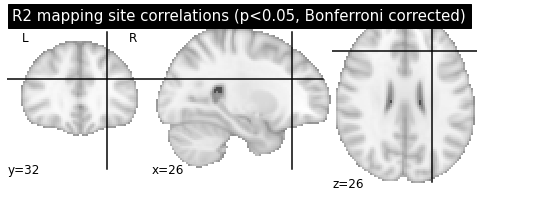

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [33]:
_, threshold = map_threshold(zmap_site, alpha=.05, height_control='bonferroni')
print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(zmap_site, threshold=threshold, 
              title='R2 mapping site correlations (p<0.05, Bonferroni corrected)')
plt.show()

get_clusters_table(zmap_site, stat_threshold=threshold, cluster_threshold=None)